In [1]:
%pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.7 MB/s eta 0:00:00


In [14]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from pathlib import Path

datapath = Path("C:/Users/mikol/Downloads/trafic_32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
datapath = Path('/content/trafic_32')

# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile(f"{datapath}.zip", 'r') as zObject:

    # Extracting specific file in the zip
    # into a specific location.
    zObject.extractall(path=datapath)
zObject.close()


KeyboardInterrupt: 

In [16]:
transform = transforms.Compose(
     [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size=64
data_set = datasets.ImageFolder(datapath, transform = transform)

In [17]:
train_dataloader = DataLoader(data_set, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 3, 32, 32])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


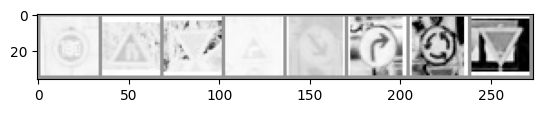

In [18]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [20]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

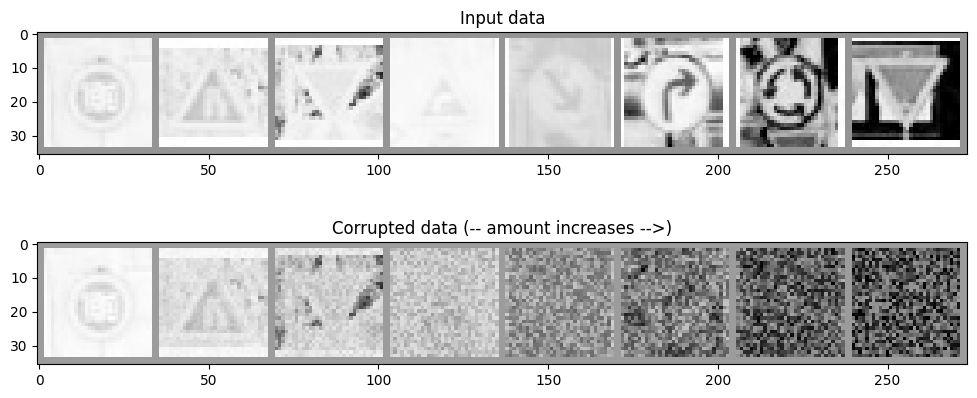

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")


In [22]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 256, kernel_size=5, padding=2),
                nn.Conv2d(256, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2, stride=1)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 5:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer
        # t = t.repeat(1,x.size(2), x.size(3), 1).permute(3,0,1,2)
        # x=torch.cat((x,t),dim=1)
        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                h_tensor = h.pop()
                if x.size() != h_tensor.size():
                    x = F.interpolate(x, size=h_tensor.size()[2:], mode='bilinear', align_corners=True)
                x += h_tensor  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 45

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

Finished epoch 0. Average loss for this epoch: 11124.806980
Finished epoch 1. Average loss for this epoch: 0.445285
Finished epoch 2. Average loss for this epoch: 0.445259
Finished epoch 3. Average loss for this epoch: 0.445301
Finished epoch 4. Average loss for this epoch: 0.445376
Finished epoch 5. Average loss for this epoch: 0.445315
Finished epoch 6. Average loss for this epoch: 0.445282
Finished epoch 7. Average loss for this epoch: 0.445390
Finished epoch 8. Average loss for this epoch: 0.445448
Finished epoch 9. Average loss for this epoch: 0.445239
Finished epoch 10. Average loss for this epoch: 0.445347
Finished epoch 11. Average loss for this epoch: 0.445284


In [ ]:
n_steps = 15
batch = 8
x = torch.rand(batch, 3, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1))
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1))